In [1]:
import os

import re
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

from wordcloud import WordCloud

In [2]:
BASE_DIR = "input/"
columns = ['Text', 'Class']
base = pd.DataFrame(columns=columns)

In [3]:
dfs = []
for file in os.listdir(BASE_DIR):
    path = os.path.join(BASE_DIR, file)
    df = pd.read_csv(path, sep="\t", header=None, names=columns)
    dfs.append(df)
base = pd.concat(dfs, ignore_index=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(base.Text, 
                                                    base.Class, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [5]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",text)
    return text.lower().split() 

In [6]:
def stemmed_words(doc):
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    return [stemmer.stem(w) for w in analyzer(doc)]

In [7]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [8]:
# vect = CountVectorizer(tokenizer=clean_text)
vect = CountVectorizer(analyzer=stemmed_words)
# vect = CountVectorizer(tokenizer=clean_text, stop_words='english', analyzer=stemmed_words)
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [9]:
param_grid = {'C': [0.1, 0.5, 1, 5, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(tf_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.5, 1, 5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [10]:
grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
y_pred = grid.predict(tf_test)

In [12]:
accuracy_score(y_test, y_pred)

0.8454545454545455

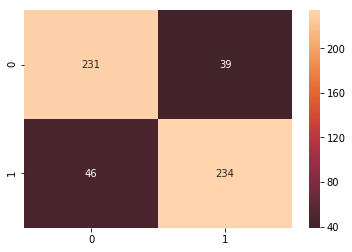

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, center=0, fmt="d")

In [14]:
df = pd.DataFrame()
df['Features'] = vect.get_feature_names()
df['Importance'] = grid.best_estimator_.coef_[0]
df['Positive'] = df['Importance'] > 0
df.sort_values(by=['Importance'], inplace=True, ascending=False)

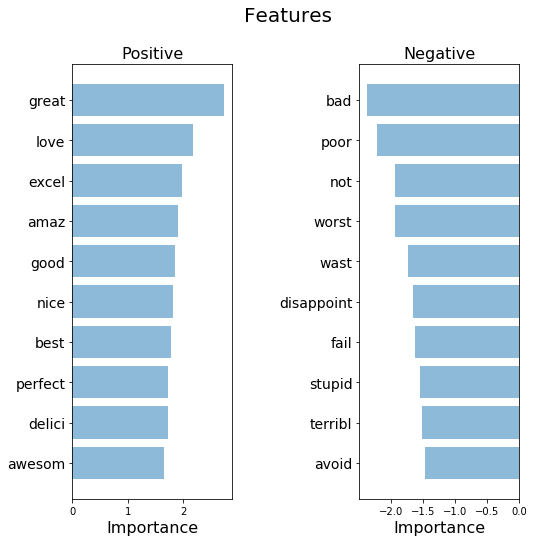

In [15]:

pos_features = df[df.Positive == True]['Features'][:10]
neg_features = df[df.Positive == False]['Features'][-10:]

pos_importance = df[df.Positive == True]['Importance'][:10]
neg_importance = df[df.Positive == False]['Importance'][-10:]

y_pos = np.arange(10)

fig = plt.figure(figsize=(8, 8))  

plt.subplot(121)
plt.barh(y_pos, pos_importance, align='center', alpha=0.5)
plt.title('Positive', fontsize=16)
plt.yticks(y_pos, pos_features, fontsize=14)
plt.gca().invert_yaxis()
plt.suptitle('Features', fontsize=20)
plt.xlabel('Importance', fontsize=16)
    
plt.subplot(122)
plt.barh(y_pos, neg_importance, align='center', alpha=0.5)
plt.title('Negative', fontsize=16)
plt.yticks(y_pos, neg_features, fontsize=14)
plt.xlabel('Importance', fontsize=16)
    
plt.subplots_adjust(wspace=0.8)
plt.show()

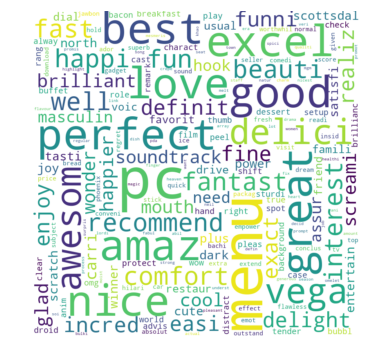

In [16]:
text = " ".join(review for review in df[df.Positive == True]['Features'])

wordcloud = WordCloud(background_color="white", width=800, height=800,max_font_size=140)
wordcloud.generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

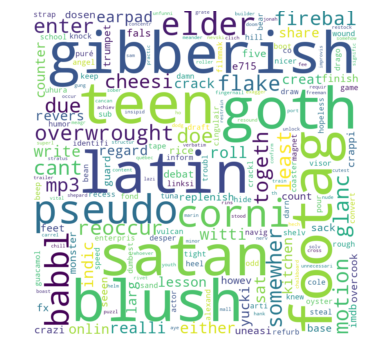

In [17]:
text = " ".join(review for review in df[df.Positive == False]['Features'])

wordcloud = WordCloud(background_color="white", width=800, height=800,max_font_size=140)
wordcloud.generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()